In [1]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/MyDrive/IntroDL_SST5_LSTM_models'
project_name = 'LSTM4_models_NoPrep'
dir = root_dir + '/' + project_name + '/'

Mounted at /content/drive


# DATASET

In [7]:
%%capture
!pip install datasets

In [8]:
from datasets import load_dataset
ds = load_dataset("SetFit/sst5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/171k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

The size of the dataset is as following:

In [9]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})

Example:

In [10]:
ds['train'][100]

{'text': "jackson tries to keep the plates spinning as best he can , but all the bouncing back and forth ca n't help but become a bit tedious -- even with the breathtaking landscapes and villainous varmints there to distract you from the ricocheting .",
 'label': 2,
 'label_text': 'neutral'}

# PREPROCESSING

In [11]:
import pandas as pd

ds_train = pd.DataFrame(ds['train'])
ds_val = pd.DataFrame(ds['validation'])
ds_test = pd.DataFrame(ds['test'])

ds_train

,text,label,label_text
0,"a stirring , funny and finally transporting re...",4,very positive
1,apparently reassembled from the cutting-room f...,1,negative
2,they presume their audience wo n't sit still f...,1,negative
3,the entire movie is filled with deja vu moments .,2,neutral
4,this is a visually stunning rumination on love...,3,positive
...,...,...,...
8539,take care is nicely performed by a quintet of ...,1,negative
8540,"the script covers huge , heavy topics in a bla...",1,negative
8541,a seriously bad film with seriously warped log...,1,negative
8542,it 's not too racy and it 's not too offensive .,2,neutral


## Split the labels

In [12]:
train_labels = ds_train["label"].values.reshape(-1, 1)
test_labels = ds_test["label"].values.reshape(-1, 1)
val_labels = ds_val["label"].values.reshape(-1, 1)
train_labels

array([[4],
       [1],
       [1],
       ...,
       [1],
       [2],
       [4]])

## Statistic of the train dataset

Class distribution

In [13]:
labels = []

for i in range(len(ds_train)):
  this_label = ds_train.at[i,'label_text']
  for j in range(len(labels)):
    if labels[j][0] == this_label:
      labels[j][1] += 1
      break
  else:
    labels.append([this_label, 1])

labels

[['very positive', 1288],
 ['negative', 2218],
 ['neutral', 1624],
 ['positive', 2322],
 ['very negative', 1092]]

Length of the sentences

In [14]:
avg_len, this_len, max_len, min_len = 0, 0, -999990, 999990

for i in range(len(ds_train)):
  this_len = len(ds_train.at[i, 'text'].split())
  if this_len > max_len:
    max_len = this_len
  if this_len < min_len:
    min_len = this_len
  avg_len += this_len
avg_len /= len(ds_train)
print('Average length: ', avg_len)
print('Max length: ', max_len)
print('Min length: ', min_len)
avg_len, this_len, max_len, min_len = 0, 0, -999990, 999990
for i in range(len(ds_val)):
  this_len = len(ds_train.at[i, 'text'].split())
  if this_len > max_len:
    max_len = this_len
  if this_len < min_len:
    min_len = this_len
  avg_len += this_len
avg_len /= len(ds_val)
print('Average length: ', avg_len)
print('Max length: ', max_len)
print('Min length: ', min_len)
avg_len, this_len, max_len, min_len = 0, 0, -999990, 999990
for i in range(len(ds_test)):
  this_len = len(ds_train.at[i, 'text'].split())
  if this_len > max_len:
    max_len = this_len
  if this_len < min_len:
    min_len = this_len
  avg_len += this_len
avg_len /= len(ds_test)

print('Average length: ', avg_len)
print('Max length: ', max_len)
print('Min length: ', min_len)

Average length:  19.143960674157302
Max length:  52
Min length:  2
Average length:  18.932788374205266
Max length:  46
Min length:  2
Average length:  19.426696832579186
Max length:  51
Min length:  2


# HYPERPARAMETERS

In [15]:
hparams = {
    "embedding_dim": 100,
    "vocab_size": 10000,
    "max_sequence_length": 50
}

# DEEP LEARNING MODEL

### Tokenize the words

- Tokenizer: Turns the sentences in to arrays of numbers.
- pad_sequences: Pads zeroes to the shorter arrays to make them be the same size.

In [16]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
import io
import json

def save_tokenizer_to_json(tokenizer, filename):
    tokenizer_json = tokenizer.to_json()
    if not filename.endswith('.json'):
        filename += '.json'
    with io.open(filename, 'w', encoding='utf-8') as f:
      f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [18]:
tokenizer = Tokenizer(num_words=hparams["vocab_size"], oov_token="oov")
tokenizer.fit_on_texts(ds_train["text"])
def prep_text(texts, tokenizer, max_sequence_length):
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, padding='post', maxlen=max_sequence_length)

train_text = prep_text(ds_train["text"], tokenizer, hparams["max_sequence_length"])
test_text = prep_text(ds_test["text"], tokenizer, hparams["max_sequence_length"])
val_text = prep_text(ds_val["text"], tokenizer, hparams["max_sequence_length"])


train_text

array([[   3, 1455,   69, ...,    0,    0,    0],
       [1456, 8234,   34, ...,    0,    0,    0],
       [  77, 8235,   71, ...,    0,    0,    0],
       ...,
       [   3,  936,   90, ...,    0,    0,    0],
       [   9,    8,   25, ...,    0,    0,    0],
       [   3, 3791, 3248, ...,    0,    0,    0]], dtype=int32)

In [19]:
test_text

array([[  58, 4349,   58, ...,    0,    0,    0],
       [   3,    1,    5, ...,    0,    0,    0],
       [ 105,  110,   30, ...,    0,    0,    0],
       ...,
       [   3,   14,   96, ...,    0,    0,    0],
       [   6,  446,   18, ...,    0,    0,    0],
       [  13,  143,    8, ...,    0,    0,    0]], dtype=int32)

In [64]:
import pickle

# saving
with open(dir+'tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Word2Vec Embedding

In [20]:
pip install gensim

In [21]:
from gensim.models import KeyedVectors

# Load the Google pre-trained Word2Vec model (binary format)
word2vec = KeyedVectors.load_word2vec_format(root_dir + '/GoogleNews-vectors-negative300.bin', binary=True)

In [22]:
import numpy as np

def create_embedding_matrix(word_index, word2vec, embedding_dim):
    vocab_size = len(word_index) + 1  # +1 for padding token
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]
    return embedding_matrix

In [23]:
from tensorflow.keras.layers import Embedding

# Create the embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300  # Google's Word2Vec uses 300 dimensions
embedding_matrix = create_embedding_matrix(word_index, word2vec, embedding_dim)

# Update the Embedding layer
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],  # vocab_size
    output_dim=embedding_matrix.shape[1],  # embedding_dim
    weights=[embedding_matrix],
    trainable=False  # Freeze the embeddings during training
)

## Build the model and tune model hyperparameters

In [3]:
%%capture
!pip install keras-tuner

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner

In [5]:
def model_builder(hp):
  model = Sequential()

  #Embedding
  model.add(embedding_layer)
  #LSTM
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(Bidirectional(LSTM(units=hp_units_lstm)))
  #Dense
  hp_units_dense = hp.Int('units_dense', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units_dense, activation='relu'))
  #Dropout
  model.add(Dropout(0.5))
  #Result
  model.add(Dense(units=5, activation='softmax'))
  #Optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[.001, .0005, .0001])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [25]:
tuner = keras_tuner.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=root_dir,
                     project_name=project_name)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from /content/drive/MyDrive/IntroDL_SST5_LSTM_models/LSTM4_models_NoPrep/tuner0.json


In [28]:
tuner.search(train_text, train_labels, epochs=5, validation_data=(val_text, val_labels), callbacks=[stop_early])

## Training

In [53]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""units_lstm {best_hps.get('units_lstm')}\n
units_dense {best_hps.get('units_dense')}\n
learning_rate {best_hps.get('learning_rate')}.
""")

model_full = tuner.hypermodel.build(best_hps)
history_full = model_full.fit(train_text, train_labels,
                    epochs=20,
                    validation_data=(val_text, val_labels)
                    )

units_lstm 96

units_dense 96

learning_rate 0.0005.

Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.2988 - loss: 1.5375 - val_accuracy: 0.4233 - val_loss: 1.3636
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.4147 - loss: 1.3295 - val_accuracy: 0.4305 - val_loss: 1.2954
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 44s 156ms/step - accuracy: 0.4435 - loss: 1.2709 - val_accuracy: 0.4323 - val_loss: 1.3037
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - accuracy: 0.4573 - loss: 1.2473 - val_accuracy: 0.4242 - val_loss: 1.2680
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.4769 - loss: 1.2097 - val_accuracy: 0.4178 - val_loss: 1.2887
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.4816 - loss: 1.1937 - val_accuracy: 0.4233 - val_loss: 1.2845
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.4967 - loss: 1.1665 - val_accuracy: 0.4269 - val_loss: 1.2870
Epoch 8/20
267/267 ━━━━━━━━━━

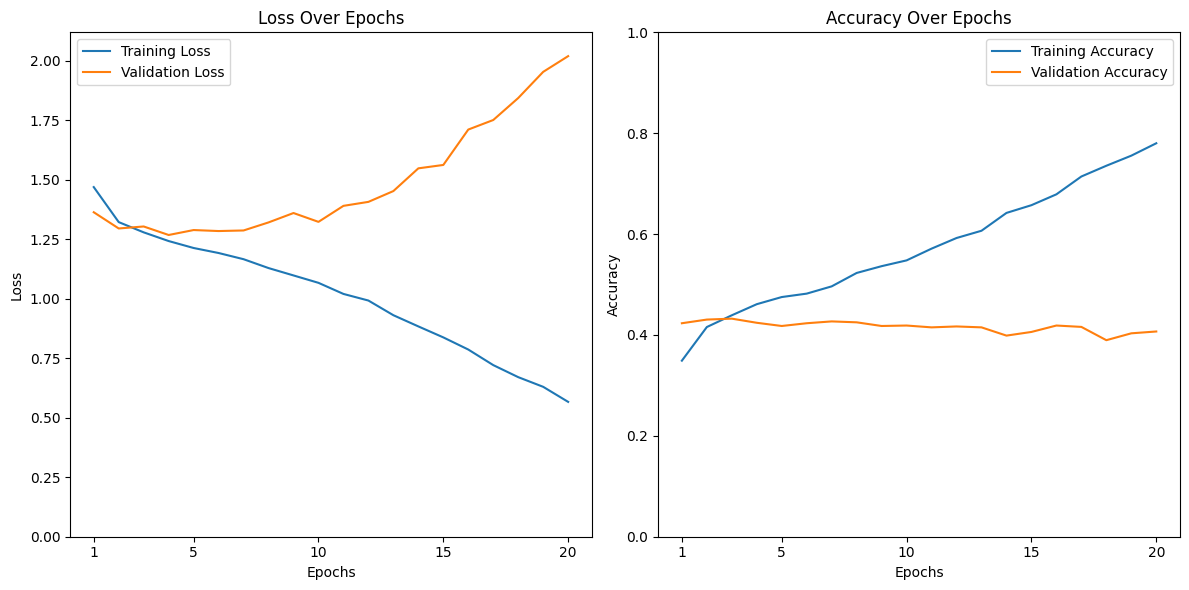

In [54]:
training_loss = history_full.history['loss']
validation_loss = history_full.history['val_loss']
training_accuracy = history_full.history['accuracy']
validation_accuracy = history_full.history['val_accuracy']

import matplotlib.pyplot as plt

# Plot Loss
epochs = range(1, len(training_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xticks([1, 5, 10, 15, 20])
plt.ylim(0, max(max(training_loss), max(validation_loss)) + 0.1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xticks([1, 5, 10, 15, 20])
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Retrain using the optimal number of epochs

In [55]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_text, train_labels,
                    epochs=7,
                    validation_data=(val_text, val_labels)
                    )

Epoch 1/7
267/267 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.2878 - loss: 1.5413 - val_accuracy: 0.3933 - val_loss: 1.3499
Epoch 2/7
267/267 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.4221 - loss: 1.3261 - val_accuracy: 0.4105 - val_loss: 1.3188
Epoch 3/7
267/267 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.4443 - loss: 1.2755 - val_accuracy: 0.4314 - val_loss: 1.2828
Epoch 4/7
267/267 ━━━━━━━━━━━━━━━━━━━━ 44s 153ms/step - accuracy: 0.4567 - loss: 1.2458 - val_accuracy: 0.4133 - val_loss: 1.3032
Epoch 5/7
267/267 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.4651 - loss: 1.2203 - val_accuracy: 0.4332 - val_loss: 1.2727
Epoch 6/7
267/267 ━━━━━━━━━━━━━━━━━━━━ 45s 159ms/step - accuracy: 0.4832 - loss: 1.1941 - val_accuracy: 0.4223 - val_loss: 1.3119
Epoch 7/7
267/267 ━━━━━━━━━━━━━━━━━━━━ 78s 145ms/step - accuracy: 0.4928 - loss: 1.1694 - val_accuracy: 0.4278 - val_loss: 1.2940


In [63]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 50, 300)               │       4,601,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (32, 192)                   │         304,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (32, 96)                    │          18,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (32, 96)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (32, 5)                     │             485 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,573,429 (21.26 MB)

 Trainable params: 323,909 (1.24 MB)

 Non-trainable params: 4,601,700 (17.55 MB)

 Optimizer params: 647,820 (2.47 MB)

# EVALUATION

In [56]:
model.save(dir + 'model.keras')

In [57]:
model = tf.keras.models.load_model(dir + 'model.keras')

In [58]:
test_result = model.evaluate(test_text, test_labels)
print("[test loss, test accuracy]:", test_result)

70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.4430 - loss: 1.2838
[test loss, test accuracy]: [1.282099962234497, 0.4420814514160156]


In [59]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(test_text)
predictions = predictions.argmax(axis=1)
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions, average='weighted')
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')

# Print results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step
Accuracy: 0.4420814479638009
F1 Score: 0.4149790881381372
Precision: 0.4548221321403573
Recall: 0.4420814479638009


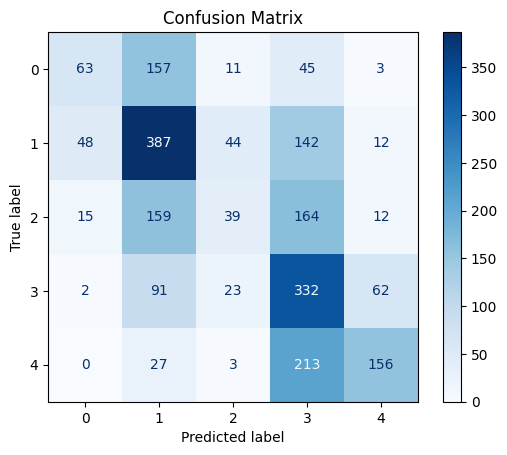

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(5))  # Use appropriate labels
disp.plot(cmap=plt.cm.Blues, values_format='d')  # Choose a color map and format
plt.title("Confusion Matrix")
plt.show()